In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

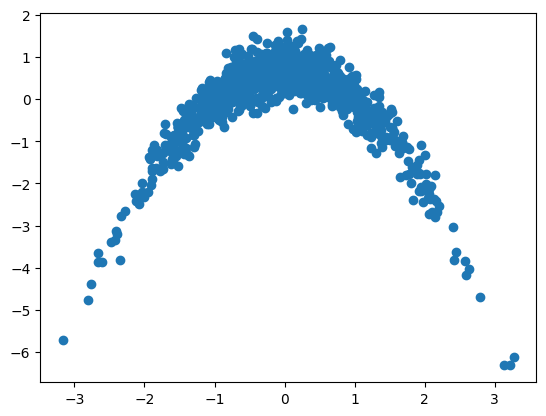

In [2]:
#target distribution q_D
N=1000
Xs = np.random.randn(2*N).reshape(N,2)
Xs[:,1]-= 2*Xs[:,0]**2
#it is alweays a good idea for diffusion to normalize data to zero mean, unit variance
Xs = (Xs - np.mean(Xs,axis=0).reshape(1,-1))/np.std(Xs,axis=0).reshape(1,-1)
plt.figure()
plt.scatter(Xs[:,0],Xs[:,1])
plt.show()

In [3]:
#neural network to learn epsilon(x_t,t). you can play around with it, but we added it for convenience
#note that this networks expects normalized values of t in 0 to 1. so divide your time index by T.
class Net(nn.Module):
    def __init__(self, num_latent_features=32, num_embedding_features=16):
        super().__init__()
        self.num_embedding_features=num_embedding_features
        self.num_latent_features = num_latent_features
        self.fc_in = nn.Linear(2, num_latent_features)
        self.fc_emb = nn.Linear(num_embedding_features, num_latent_features)
        self.fc1 = nn.Linear(num_latent_features, num_latent_features)
        self.fc2 = nn.Linear(num_latent_features, num_latent_features)
        self.fc_out = nn.Linear(num_latent_features, 2)

    def embedding(self, t):
        #We assume that t is a n-dimensional vector with values in [0,1]
        #each element in t gives the time for each element in the batch
        num_frequencies = self.num_embedding_features // 2
        frequencies = torch.logspace(0,3,num_frequencies,device=t.device, dtype=t.dtype)
        cos_feats = torch.cos(2*np.pi*frequencies.unsqueeze(0)*t.unsqueeze(1))
        sin_feats = torch.sin(2*np.pi*frequencies.unsqueeze(0)*t.unsqueeze(1))
        return torch.hstack([cos_feats,sin_feats])
        
    def forward(self, x,t):
        t_embedding = self.embedding(t)
        #Create sinusoidal features and apply the silu activation
        t_embedding = torch.nn.functional.silu(self.embedding(t))

        #linear combination of space and time features
        x = F.silu(self.fc_in(x) + self.fc_emb(t_embedding))
        #now apply a simple feed forward network with relu activations.
        #note: we skip dropout for simplicity.
        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        #transform back
        x = self.fc_out(x)
        return x

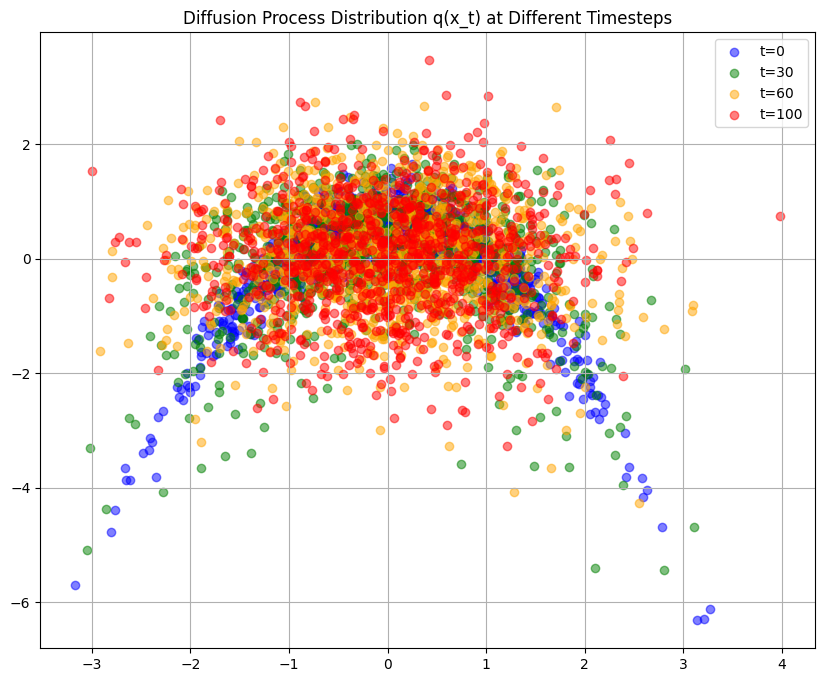

In [5]:
#Task 1: for the given set of T and beta plot the generating distribution q(X_t) for different t=0,30,60,100
# As beta we use the scheme proposed in the lecture
T=100
ts = np.linspace(0,1,T+1)
s=0.08
gs=np.cos(np.pi/2*((ts+s)/(1+s)))**2
betas = np.minimum(1- gs[1:]/gs[:-1],0.999)

# Calculate alphas and cumulative products
alphas = 1 - betas
alphas_bar = np.cumprod(alphas)

# Plot distributions for different timesteps
plt.figure(figsize=(10,8))
t_steps = [0, 30, 60, 100]
colors = ['blue', 'green', 'orange', 'red']

for t, color in zip(t_steps, colors):
    # For t=0, use original data distribution
    if t == 0:
        x_t = Xs
    else:
        # Calculate mean and variance for q(x_t|x_0)
        mean = np.sqrt(alphas_bar[t-1]).reshape(1,1) * Xs
        var = (1 - alphas_bar[t-1])
        # Sample from q(x_t|x_0)
        noise = np.random.normal(0, 1, size=Xs.shape)
        x_t = mean + np.sqrt(var).reshape(1,1) * noise
    
    plt.scatter(x_t[:,0], x_t[:,1], c=color, alpha=0.5, label=f't={t}')

plt.title('Diffusion Process Distribution q(x_t) at Different Timesteps')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
#Task 2: implement the loss function for gradient descent (eq 76 in th script, or L_simple in the background material)
#implement by sampling a random time step t in 0,..,T
#params: 
#    Xs: a batch of samples from the dataset.
#    model: the model for learning epsilon.
def loss(Xs, model):
    # Sample random timestep t for each sample in batch
    batch_size = Xs.shape[0]
    t = torch.randint(1, T+1, (batch_size,))
    
    # Get alpha_bar for the sampled timesteps
    alpha_bar_t = torch.tensor(alphas_bar[t-1], dtype=torch.float32)
    
    # Sample noise
    epsilon = torch.randn_like(Xs)
    
    # Get noisy samples x_t using reparametrization
    x_t = torch.sqrt(alpha_bar_t.reshape(-1,1)) * Xs + \
          torch.sqrt(1 - alpha_bar_t.reshape(-1,1)) * epsilon
    
    # Get model prediction of noise
    epsilon_pred = model(x_t, t)
    
    # Calculate MSE loss between true and predicted noise
    loss = torch.mean((epsilon - epsilon_pred) ** 2)
    
    return loss

In [7]:
#train loop. added for your convenience.
train_loader = torch.utils.data.DataLoader(torch.tensor(Xs,dtype=torch.float32), batch_size=10)
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
num_epochs = 0
for e in range(num_epochs):
    if e % (num_epochs//10) == 0:
        print("epoch:",e)
    for data in train_loader:
        optimizer.zero_grad()
        l = loss(data,model) 
        l.backward()
        optimizer.step()

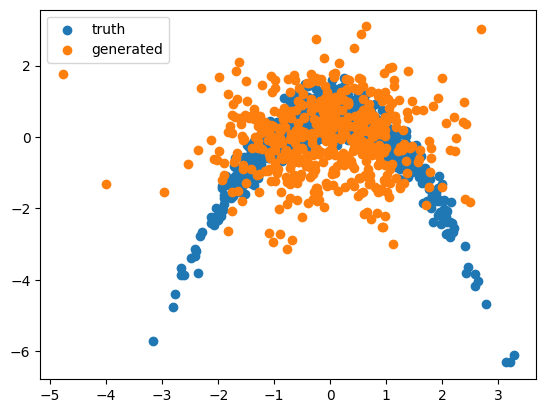

In [8]:
#Task 3: generate samples from the learned model
#num: number of samples to generate
#model: the trained model
def generate_samples(model, num):
    Xs =  torch.normal(0.0,1.0,size=(num,2),dtype=torch.float32)
    return Xs
samples = generate_samples(model,500).detach().numpy()

plt.figure()
plt.scatter(Xs[:,0],Xs[:,1],label="truth")
plt.scatter(samples[:,0],samples[:,1],label="generated")
plt.legend()
plt.show()